# Merging of *scRNA-Seq* datasets ***Guo et al. (2023)*** & ***Conchola et al., (2023)*** & ***Candeli et al., (2025)***

## Imports

In [1]:
import scanpy as sc
import hdf5plugin
import anndata as ad
import matplotlib as mpl
import scvelo as scv
import anndata
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

## Figure Settings

In [2]:
# Set font types to ensure text is editable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42   # For PDF export
mpl.rcParams['ps.fonttype'] = 42    # For PS export
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.dpi'] = 600

# Scanpy figure settings
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=600, 
                     frameon=False, vector_friendly=True, fontsize=12, 
                     figsize=(5,4), color_map=None, format='pdf', facecolor=None, 
                     transparent=False, ipython_format='png')

# scVelo figure settings
scv.set_figure_params(style='scvelo', dpi=80, dpi_save=600, 
                      frameon=False, vector_friendly=True, transparent=True, fontsize=12, 
                      figsize=(5,4), color_map=None, facecolor=None, format='pdf', ipython_format='png')

# Set figure directory
sc.settings.figdir = './figures/'
scv.settings.figdir = './figures/'

# Fine-tune Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['figure.subplot.wspace'] = 0.99
plt.rcParams['axes.grid'] = False

import logging
# Suppress INFO messages
logging.getLogger("fontTools").setLevel(logging.WARNING)
plt.set_loglevel('WARNING') 

## Inspect matrixes AnnData

In [3]:
import numpy as np
from scipy.sparse import issparse

def matrix_summary(adata):
    """
    Prints min, max, and mean for expression matrix, counts layer, raw matrix,
    and scaled layer of an AnnData object.

    Parameters:
        adata: AnnData
    """

    # Helper function to compute min, max, mean
    def summary(matrix, name):
        if issparse(matrix):
            matrix = matrix.toarray()
        flat = matrix.flatten()
        mean_value = flat.mean()
        print(f"{name}: min={flat.min()}, max={flat.max()}, mean={mean_value}")

    # Expression matrix
    summary(adata.X, "Expression matrix (X)")

    # Counts layer
    if 'counts' in adata.layers:
        summary(adata.layers['counts'], "Counts layer matrix (layers['counts'])")
    else:
        print("Counts layer not found in adata.layers.")

    # Raw matrix
    if adata.raw is not None:
        summary(adata.raw.X, "Raw matrix (raw.X)")
    else:
        print("Raw matrix not found in adata.raw.")

    # Scaled layer
    if 'scaled' in adata.layers:
        summary(adata.layers['scaled'], "Scaled layer matrix (layers['scaled'])")
    else:
        print("Scaled layer not found in adata.layers.")


## Loading and merging individual datasets

### Guo et et al., (2023)

In [4]:
guo_adata = sc.read_h5ad('./data/Guo2023/Guo2023_AdultLung_processed.h5ad')
guo_adata.X = guo_adata.layers['counts'].copy()
guo_adata.obs['Tissue'] = 'Adult Lung Epithelium'

del guo_adata.layers
del guo_adata.raw

guo_adata

AnnData object with n_obs × n_vars = 135863 × 32284
    obs: 'Sample ID', 'Patient ID', 'Dataset', 'Age', 'Sex', 'lineage_level1', 'lineage_level2', 'celltype_level1', 'celltype_level2', 'annotation', 'celltype_level3_fullname', 'Lung-Region', 'Reference', 'Tissue', 'Technique', 'Time point', 'Region', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp'
    var: 'features', 'gencode_og_name', 'gencode_og_id', 'gencode_v44_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Dataset_colors', 'Lung-Region_colors', 'Reference_colors', 'Region_colors', 'annotation_colors', 'celltype_level3_colors', 'hvg', 'lineage_level1_colors', 'log1p'
    obsm: 'X_pca', 'X_umap'

In [5]:
for cat in guo_adata.obs['annotation'].unique():
    print(cat)

Serous
Mucous
SMG Basal/Duct
Goblet
MEC
Secretory
Ionocyte
Ciliated
Suprabasal
Basal
AT2
Deuterosomal
Tuft
PNEC
AT1
RAS


### Conchola et al., (2023)

In [6]:
conchola_adata = sc.read_h5ad('./data/Conchola2023/Conchola2023_FetalEpithelium_processed.h5ad')
conchola_adata.X = conchola_adata.layers['counts'].copy()
conchola_adata.obs['Reference'] = 'Conchola et al., (2023)'
conchola_adata.obs['Tissue'] = 'Fetal Lung Epithelium'

del conchola_adata.layers
del conchola_adata.raw

conchola_adata

AnnData object with n_obs × n_vars = 10614 × 24373
    obs: 'Patient ID', 'annotation', 'Tissue', 'Region', 'Time point', 'Sample ID', 'Technique', 'Reference', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp'
    var: 'gencode_og_name', 'gencode_og_id', 'gencode_v44_name', 'summed_genes', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Reference_colors', 'hvg', 'log1p'

In [7]:
# Standardize cell annotations
category_mapping = {
    'Lower Airway Progenitor': 'LAP',
    'Neuroendocrine': 'PNEC',
}
conchola_adata.obs['annotation'] = conchola_adata.obs['annotation'].replace(category_mapping)
for cat in conchola_adata.obs['annotation'].unique():
    print(cat)
conchola_adata.obs['annotation_v2'] = list(conchola_adata.obs['annotation'])

Basal
LAP
Multiciliated Precursor
Goblet-like Secretory
Multiciliated
PNEC
Club-like Secretory
Bud Tip Adjacent
Bud Tip Progenitor
Unknown


### Candeli et al., (2025)

In [8]:
candeli_adata = sc.read_h5ad('./data/NEr_fAOs_batch_corrected.h5ad')
del candeli_adata.uns
candeli_adata.X = candeli_adata.layers['counts'].copy()
del candeli_adata.layers
del candeli_adata.raw
candeli_adata

AnnData object with n_obs × n_vars = 5441 × 32191
    obs: 'Sample ID', 'Media', 'Time point', 'Patient ID', 'Passage', 'Gestational Week', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'gene_ids', 'feature_types', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'prev_X_pca'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [9]:
candeli_adata.obs['Technique'] = 'SORT-seq'
candeli_adata.obs['Reference'] = 'Candeli et al., (2025)'
candeli_adata.obs['Tissue'] = 'fAOs'
candeli_adata.obs['Region'] = 'fAOs'

cols_to_keep = [
    'Sample ID', 'Patient ID', 'Tissue','Time point','Technique', 'Reference','Region']

### Merging

In [10]:
# Version retaining all genes across datasets (Union)
merged_adata = ad.concat(
    [guo_adata, conchola_adata, candeli_adata],
    join= 'outer',
    axis= 0,
    fill_value= 0
)
merged_adata

AnnData object with n_obs × n_vars = 151918 × 48206
    obs: 'Sample ID', 'Patient ID', 'Dataset', 'Age', 'Sex', 'lineage_level1', 'lineage_level2', 'celltype_level1', 'celltype_level2', 'annotation', 'celltype_level3_fullname', 'Lung-Region', 'Reference', 'Tissue', 'Technique', 'Time point', 'Region', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'annotation_v2', 'Media', 'Passage', 'Gestational Week', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden'
    obsm: 'X_pca', 'X_umap', 'X_draw_graph_fa', 'X_pca_harmony', 'prev_X_pca'

In [11]:
category_counts = merged_adata.obs['Reference'].value_counts()
category_counts

Guo et al., (2023)              43238
Goldfarbmuren et al., (2020)    27395
Reyfman et al., (2019)          20099
Deprez et al., (2020)           13720
Conchola et al., (2023)         10614
Melms et al., (2021)             9406
Travaglini et al., (2020)        8058
Habermann et al., (2019)         7447
Adams et al., (2020)             6500
Candeli et al., (2025)           5441
Name: Reference, dtype: int64

In [12]:
category_counts = merged_adata.obs['Tissue'].value_counts()
category_counts

Adult Lung Epithelium    135863
Fetal Lung Epithelium     10614
fAOs                       5441
Name: Tissue, dtype: int64

In [13]:
merged_adata.obs

,Sample ID,Patient ID,Dataset,Age,Sex,lineage_level1,lineage_level2,celltype_level1,celltype_level2,annotation,...,pct_counts_rp,annotation_v2,Media,Passage,Gestational Week,n_genes,S_score,G2M_score,phase,leiden
Donor27_Donor27_AAACGAACACCGTGCA-1,CCHMC_SMG_Donor27,CCHMC_SMG_Donor27,CCHMC_LungMAP,45.0,M,Epithelial,Epithelial_Glandular,Serous,Serous,Serous,...,14.501646,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Donor27_Donor27_AAAGAACAGCGCCATC-1,CCHMC_SMG_Donor27,CCHMC_SMG_Donor27,CCHMC_LungMAP,45.0,M,Epithelial,Epithelial_Glandular,Serous,Serous,Serous,...,13.312487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Donor27_Donor27_AAAGAACCAGGCAATG-1,CCHMC_SMG_Donor27,CCHMC_SMG_Donor27,CCHMC_LungMAP,45.0,M,Epithelial,Epithelial_Glandular,Serous,Serous,Serous,...,14.848321,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Donor27_Donor27_AAAGTGACACGGCCAT-1,CCHMC_SMG_Donor27,CCHMC_SMG_Donor27,CCHMC_LungMAP,45.0,M,Epithelial,Epithelial_Glandular,Mucous,Mucous,Mucous,...,23.611600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Donor27_Donor27_AAATGGACAAAGGAGA-1,CCHMC_SMG_Donor27,CCHMC_SMG_Donor27,CCHMC_LungMAP,45.0,M,Epithelial,Epithelial_Glandular,Mucous,Mucous,Mucous,...,20.172057,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
s007.152,s007,125e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.132412,NaN,NE Differentiation,P7,week_17,2478.0,-0.099528,-0.102583,G1,0
s007.154,s007,125e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,15.218870,NaN,NE Differentiation,P7,week_17,3755.0,0.011518,-0.067342,S,2
s007.155,s007,125e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.079470,NaN,NE Differentiation,P7,week_17,1580.0,0.001951,-0.088909,S,2
s007.156,s007,125e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23.331860,NaN,NE Differentiation,P7,week_17,2790.0,-0.001032,-0.074496,G1,0


### Saving merged *AnnData*

In [14]:
merged_adata.write_h5ad(
    './data/MergedDatasets/Merged_LungEpithelium.h5ad',
    compression=hdf5plugin.FILTERS["zstd"],
    compression_opts=hdf5plugin.Zstd(clevel=5).filter_options
)

del conchola_adata
del candeli_adata
del merged_adata

## Preprocessing

In [15]:
merged_adata = sc.read_h5ad('./data/MergedDatasets/Merged_LungEpithelium.h5ad')
merged_adata

AnnData object with n_obs × n_vars = 151918 × 48206
    obs: 'Sample ID', 'Patient ID', 'Dataset', 'Age', 'Sex', 'lineage_level1', 'lineage_level2', 'celltype_level1', 'celltype_level2', 'annotation', 'celltype_level3_fullname', 'Lung-Region', 'Reference', 'Tissue', 'Technique', 'Time point', 'Region', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'annotation_v2', 'Media', 'Passage', 'Gestational Week', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'X_umap', 'prev_X_pca'

In [16]:
matrix_summary(merged_adata)

Expression matrix (X): min=0.0, max=61871.0, mean=0.2681641768535817
Counts layer not found in adata.layers.
Raw matrix not found in adata.raw.
Scaled layer not found in adata.layers.


### Quality check

In [17]:
sc.pp.calculate_qc_metrics(merged_adata, percent_top= None, log1p= False, inplace= True)

In [18]:
# Annotate the group of mitochondrial genes as 'mt'
merged_adata.var['mt'] = merged_adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(merged_adata, qc_vars= ['mt'], percent_top= None, log1p= False, inplace= True)

# Display genes
merged_adata.var.loc[merged_adata.var.index.str.startswith('MT-')]

,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,mt
MT-ATP6,143196,132.184731,5.741255,20081240.0,True
MT-ATP8,59156,4.938177,61.060572,750198.0,True
MT-CO1,143612,180.457477,5.467423,27414739.0,True
MT-CO2,143355,159.220816,5.636593,24188508.0,True
MT-CO3,139995,157.447505,7.848313,23919110.0,True
MT-CYB,142541,91.520564,6.172409,13903621.0,True
MT-ND1,141980,76.689023,6.541687,11650443.0,True
MT-ND2,142107,51.554141,6.458089,7832002.0,True
MT-ND3,143063,79.296245,5.828802,12046527.0,True
MT-ND4,139880,91.243487,7.924012,13861528.0,True


In [19]:
# annotate the group of ribosomal genes as 'rp'
merged_adata.var['rp'] = merged_adata.var_names.str.startswith('RP')
sc.pp.calculate_qc_metrics(merged_adata, qc_vars=['rp'], percent_top= None, log1p= False, inplace= True)

# Display genes
merged_adata.var.loc[merged_adata.var.index.str.startswith('RP')]

,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,mt,rp
RP1,15630,0.499329,89.711555,75857.0,False,True
RP1-102H19.8,589,0.004265,99.612291,648.0,False,True
RP1-111B22.3,12,0.000079,99.992101,12.0,False,True
RP1-122P22.2,58,0.000382,99.961822,58.0,False,True
RP1-127C7.6,2,0.000013,99.998684,2.0,False,True
...,...,...,...,...,...,...
RPTOR,12096,0.093939,92.037810,14271.0,False,True
RPUSD1,17205,0.149317,88.674811,22684.0,False,True
RPUSD2,12040,0.088429,92.074672,13434.0,False,True
RPUSD3,28616,0.241097,81.163522,36627.0,False,True


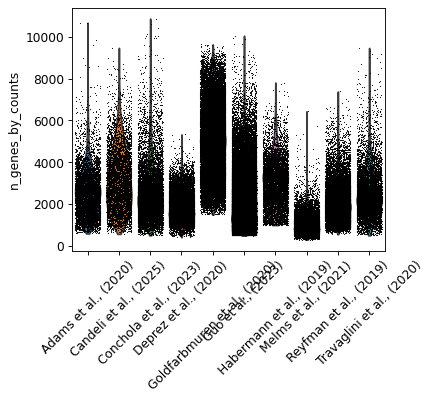

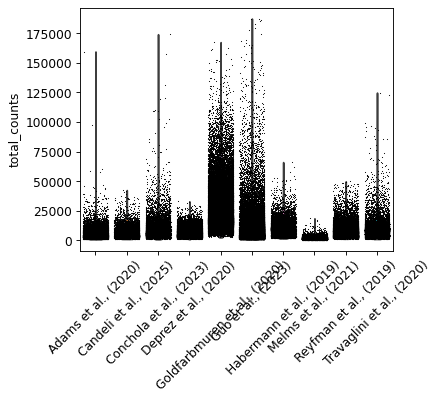

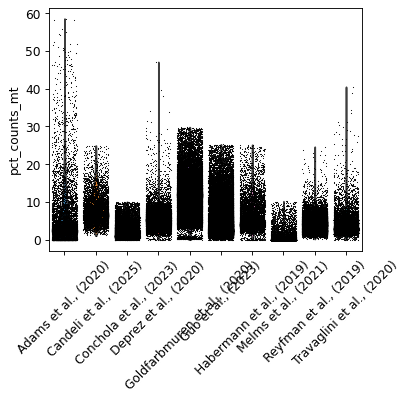

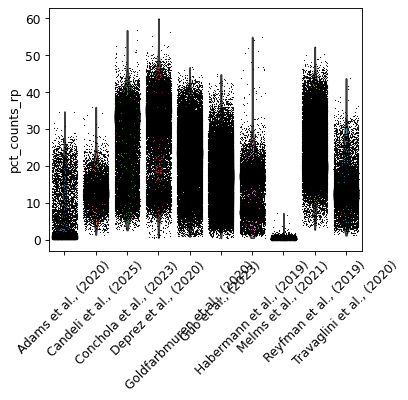

In [20]:
sc.pl.violin(merged_adata, 'n_genes_by_counts', jitter= 0.4, groupby= 'Reference', rotation= 45)
sc.pl.violin(merged_adata, 'total_counts', jitter= 0.4, groupby= 'Reference', rotation= 45)
sc.pl.violin(merged_adata, 'pct_counts_mt', jitter= 0.4, groupby= 'Reference', rotation= 45)
sc.pl.violin(merged_adata, 'pct_counts_rp', jitter= 0.4, groupby= 'Reference', rotation= 45)

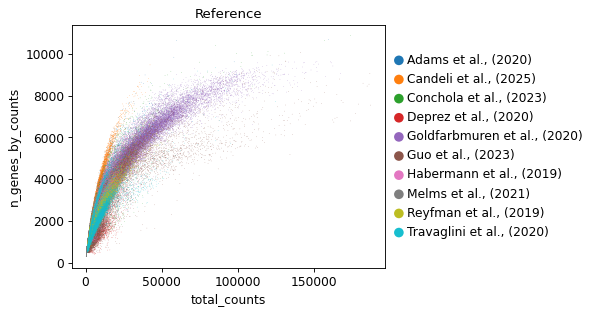

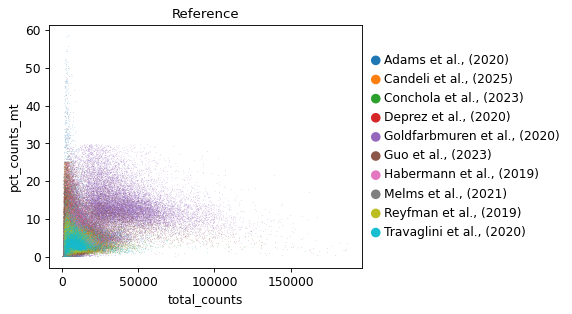

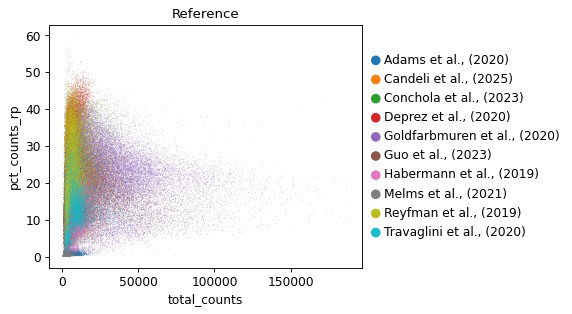

In [21]:
sc.pl.scatter(merged_adata, x= 'total_counts', y= 'n_genes_by_counts', color= 'Reference')
sc.pl.scatter(merged_adata, x= 'total_counts', y= 'pct_counts_mt', color= 'Reference')
sc.pl.scatter(merged_adata, x= 'total_counts', y= 'pct_counts_rp', color= 'Reference')

## Normalization & Highly Variable Genes

In [22]:
# Save counts layer
merged_adata.layers["counts"] = merged_adata.X.copy()
merged_adata.raw = merged_adata.copy()

#  Normalize counts per cell.
# Normalize each cell by total counts over all genes, so that every cell has the same total count after normalization
sc.pp.normalize_total(merged_adata, target_sum=1e4)

#Logarithmize the data matrix.
#Computes X = log (X=1), where X denotes the natural logarithm unless a different base is given.
sc.pp.log1p(merged_adata)

# Save raw expression matrix
merged_adata.raw = merged_adata.copy()
merged_adata

AnnData object with n_obs × n_vars = 151918 × 48206
    obs: 'Sample ID', 'Patient ID', 'Dataset', 'Age', 'Sex', 'lineage_level1', 'lineage_level2', 'celltype_level1', 'celltype_level2', 'annotation', 'celltype_level3_fullname', 'Lung-Region', 'Reference', 'Tissue', 'Technique', 'Time point', 'Region', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'annotation_v2', 'Media', 'Passage', 'Gestational Week', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'rp'
    uns: 'Reference_colors', 'log1p'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'X_umap', 'prev_X_pca'
    layers: 'counts'

In [23]:
matrix_summary(merged_adata)

Expression matrix (X): min=0.0, max=8.921513587731544, mean=0.05605911115896532


Counts layer matrix (layers['counts']): min=0.0, max=61871.0, mean=0.2681641768535817


Raw matrix (raw.X): min=0.0, max=8.921513587731544, mean=0.05605911115896532
Scaled layer not found in adata.layers.


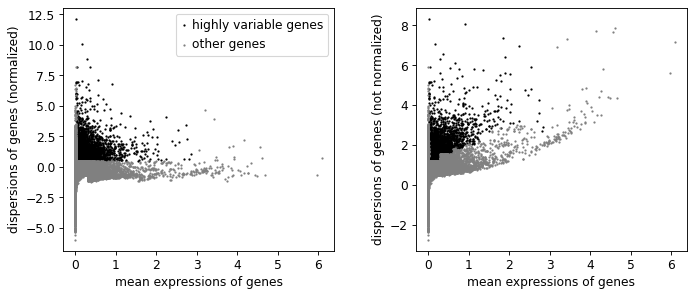

In [24]:
# Identify highly variable genes and mark them
sc.pp.highly_variable_genes(merged_adata, layer= None, n_top_genes= None, min_disp= 0.5, min_mean= 0.0125,
                                max_mean= 3, span= 0.3, n_bins= 20, flavor= 'seurat', 
                                subset= False, inplace= True, batch_key= None, check_values= True)
sc.pl.highly_variable_genes(merged_adata)

## Regress out (mostly) unwanted sources of variation.

In [25]:
# Parsing of Cell Cycle genes file

cell_cycle_genes = [x.strip() for x in open ('./data/annotations_aux_files/regev_lab_cell_cycle_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in merged_adata.var_names]

In [26]:
# Score all genes using our S and G2M phase gene lists
sc.tl.score_genes_cell_cycle(merged_adata, s_genes= s_genes, g2m_genes= g2m_genes)

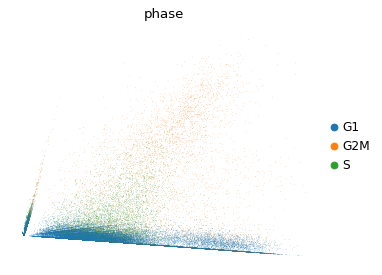

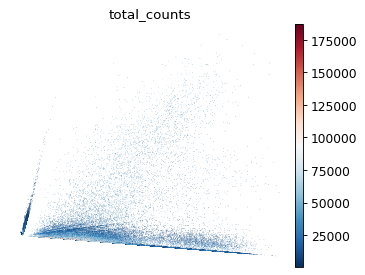

In [27]:
# We will plot the PCA of the cell cycle genes' source of variation
adata_cc_genes = merged_adata[:, cell_cycle_genes].copy()
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color= 'phase')
sc.pl.pca_scatter(adata_cc_genes, color= 'total_counts')
del adata_cc_genes

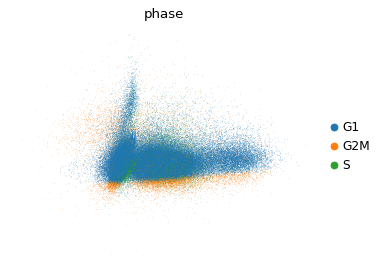

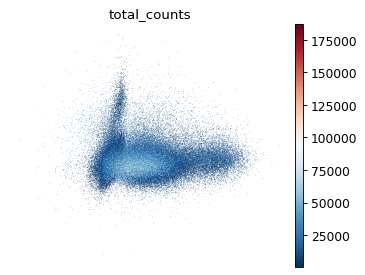

In [28]:
# Regress out the cell cycle genes' source of variation and plot PCA again
sc.pp.regress_out(merged_adata, ["total_counts", 'S_score', 'G2M_score', 'pct_counts_mt'])
adata_cc_genes = merged_adata[:, cell_cycle_genes].copy()
sc.tl.pca(adata_cc_genes)
sc.pl.pca_scatter(adata_cc_genes, color='phase')
sc.pl.pca_scatter(adata_cc_genes, color= 'total_counts')

## Scaling of data

In [29]:
# Scale data to unit variance and zero mean store results in layer
# Variables (genes) that do not display any variation (are constant across all observations) 
# are retained and set to 0 during this operation. In the future, they might be set to NaNs.

merged_adata.layers["scaled"] = sc.pp.scale(merged_adata, copy=True).X.copy()
merged_adata

AnnData object with n_obs × n_vars = 151918 × 48206
    obs: 'Sample ID', 'Patient ID', 'Dataset', 'Age', 'Sex', 'lineage_level1', 'lineage_level2', 'celltype_level1', 'celltype_level2', 'annotation', 'celltype_level3_fullname', 'Lung-Region', 'Reference', 'Tissue', 'Technique', 'Time point', 'Region', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'annotation_v2', 'Media', 'Passage', 'Gestational Week', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Reference_colors', 'log1p', 'hvg'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'X_umap', 'prev_X_pca'
    layers: 'counts', 'scaled'

In [30]:
matrix_summary(merged_adata)

Expression matrix (X): min=-7.638949835927163, max=9.66473920075979, mean=1.145746924527231e-16


Counts layer matrix (layers['counts']): min=0.0, max=61871.0, mean=0.2681641768535817


Raw matrix (raw.X): min=0.0, max=8.921513587731544, mean=0.05605911115896532


Scaled layer matrix (layers['scaled']): min=-13.346395883074562, max=389.7640208462417, mean=2.566466205925871e-16


## Compute PCA

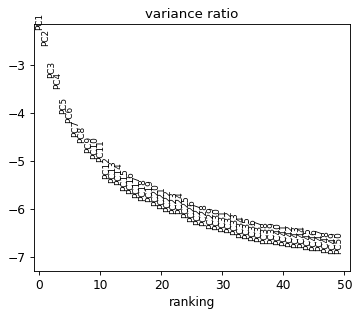

In [31]:
sc.tl.pca(merged_adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pl.pca_variance_ratio(merged_adata, log=True,n_pcs=50)

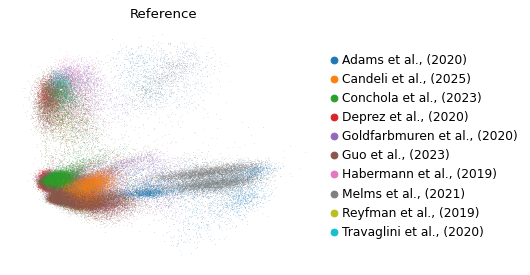

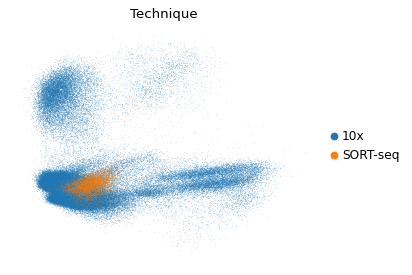

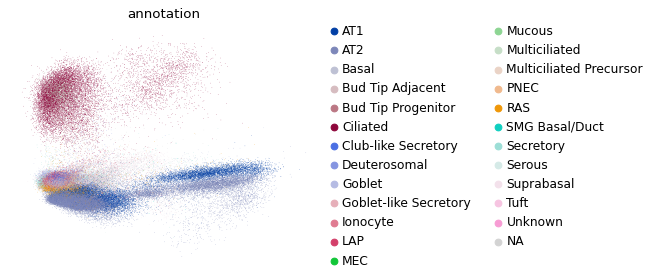

In [32]:
sc.pl.pca_scatter(merged_adata, color= 'Reference')
sc.pl.pca_scatter(merged_adata, color= 'Technique')
sc.pl.pca_scatter(merged_adata, color= 'annotation')

## Saving highly-variable-genes and processed *AnnData*

In [33]:
merged_adata.write_h5ad(
    './data/MergedDatasets/Merged_LungEpithelium_processed.h5ad',
    compression= hdf5plugin.FILTERS["zstd"],
    compression_opts= hdf5plugin.Zstd(clevel=5).filter_options
)

In [34]:
merged_adata = sc.read_h5ad('./data/MergedDatasets/Merged_LungEpithelium_processed.h5ad')
merged_adata

AnnData object with n_obs × n_vars = 151918 × 48206
    obs: 'Sample ID', 'Patient ID', 'Dataset', 'Age', 'Sex', 'lineage_level1', 'lineage_level2', 'celltype_level1', 'celltype_level2', 'annotation', 'celltype_level3_fullname', 'Lung-Region', 'Reference', 'Tissue', 'Technique', 'Time point', 'Region', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_rp', 'pct_counts_rp', 'annotation_v2', 'Media', 'Passage', 'Gestational Week', 'n_genes', 'S_score', 'G2M_score', 'phase', 'leiden'
    var: 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt', 'rp', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Reference_colors', 'Technique_colors', 'annotation_colors', 'hvg', 'log1p', 'pca'
    obsm: 'X_draw_graph_fa', 'X_pca', 'X_pca_harmony', 'X_umap', 'prev_X_pca'
    varm: 'PCs'
    layers: 'counts', 'scaled'